In [87]:
import argparse
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os.path as osp
import pickle
from tqdm import tqdm
import random
from scipy.optimize import minimize
from scipy.stats import norm
import seaborn as sns

plt.rcParams['font.family'] = 'Times New Roman'


In [88]:
def get_recurrence_quantification(src, istime=False, min_ts=None, step=None, recur_matrix=None, color_dict=None):
    neighs, ts, eid  = ext_full_indices[src], ext_full_ts[src], ext_full_eid[src]
    intervals = []
    if not istime:
        recur_matrix = np.zeros((len(neighs), len(neighs)))
    else:
        pass
    for i in range(len(neighs)):
        for j in range(i+1, len(neighs)):
            if (neighs[j] == neighs[i]):
                idxi, idxj = (i, j) if not istime else (int((ts[i] - min_ts) // step), int((ts[j] - min_ts) // step))
                try:
                    recur_matrix[idxi][idxj] += 1
                except IndexError:
                    import pdb; pdb.set_trace()
    if not istime:
        return recur_matrix, np.sum(recur_matrix)

def tsort_original(i, indices, ts, eid):
    if not len(indices):
        return
    try:
        sidx = np.argsort(ts)
        indices = np.array(indices)[sidx]
        ts = np.array(ts)[sidx]
        eid = np.array(eid)[sidx]
    except TypeError:
        import pdb; pdb.set_trace()


In [89]:
parser = argparse.ArgumentParser()
parser.add_argument('--data', type=str, help='dataset name')
parser.add_argument('--all_data', action='store_true')
parser.add_argument('--add_reverse', default=False, action='store_true')
parser.add_argument('--bins', type=int, default=-1)
parser.add_argument('--fontsize', type=int, default=32, help='font size')
parser.add_argument('--file_path', type=str, default='')
args = parser.parse_args(args=['--all_data', '--bins', '1000'])
plt.rcParams['font.size'] = args.fontsize
print(args)

datasets = ['WIKI', 'REDDIT', 'Flights', 'LASTFM', 'mooc', 'uci', 'CollegeMsg']
show_datasets = {
    'WIKI': 'Wikipedia',
    'REDDIT': 'REDDIT',
    'Flights': 'Flights',
    'LASTFM': 'LASTFM',
    'mooc': 'MOOC',
    'uci': 'UCI',
    'CollegeMsg': 'CollegeMsg'
}
if not args.all_data:
    assert args.data in datasets
    datasets = [args.data,]
else:
    datasets = ['WIKI', 'uci', 'REDDIT', 'Flights']

total_matrices = []

Namespace(data=None, all_data=True, add_reverse=False, bins=1000, fontsize=32, file_path='')


In [90]:
for data in datasets:
    df = pd.read_csv('../DATA/{}/edges.csv'.format(data))
    s = 'src' if 'src' in df.columns else 'u'
    d = 'dst' if 'dst' in df.columns else 'i'
    t = 'time' if 'time' in df.columns else 'ts'
    num_nodes = max(int(df[s].max()), int(df[d].max())) + 1
    print('num_nodes: ', num_nodes)
    # BINS = 1000 if data in ['uci', 'CollegeMsg'] else 10000
    BINS = int(min(10 ** int(np.log10(len(df)) - 1), 1e4)) if (args.bins == -1) else args.bins

    file_path = f'../figures/data/{data}_recur_time.pkl'
    if osp.exists(file_path):
        print('loading...')
        with open(file_path, 'rb') as f:
            all_data = pickle.load(f)
            ext_full_indptr, ext_full_indices, ext_full_ts, ext_full_eid = all_data['indptr'], \
            all_data['indices'], all_data['ts'], all_data['eid']
            recur_matrix = all_data['recur']
            min_ts, step = all_data['min_ts'], all_data['step']
    else:
        assert not args.all_data, 'Prepare data!'
        print('sorting and analyzing...')
        ext_full_indptr = np.zeros(num_nodes + 1, dtype=np.int32)
        ext_full_indices = [[] for _ in range(num_nodes)]
        ext_full_ts = [[] for _ in range(num_nodes)]
        ext_full_eid = [[] for _ in range(num_nodes)]

        for idx, row in tqdm(df.iterrows(), total=len(df)):
            src = int(row[s])
            dst = int(row[d])
            
            ext_full_indices[src].append(dst)
            ext_full_ts[src].append(row[t])
            ext_full_eid[src].append(idx)
            
            if args.add_reverse:
                ext_full_indices[dst].append(src)
                ext_full_ts[dst].append(row[t])
                ext_full_eid[dst].append(idx)

        for i in tqdm(range(num_nodes)):
            ext_full_indptr[i + 1] = ext_full_indptr[i] + len(ext_full_indices[i])
        tmp = np.array(list(itertools.chain(*ext_full_ts)))
        min_ts = np.min(tmp)
        max_ts = np.max(tmp)
        print(f'Bins: {BINS}\t Time span: {min_ts} - {max_ts}')
        time_bins, step = np.linspace(min_ts, max_ts, BINS+1, retstep=True)
        recur_matrices = []
        color_dict = {}
        recur_matrix = np.zeros((BINS+1, BINS+1))
        for i in tqdm(range(num_nodes)):
            tsort_original(i, ext_full_indices[i], ext_full_ts[i], ext_full_eid[i])
            get_recurrence_quantification(i, True, min_ts, step, recur_matrix, color_dict)
        with open(args.file_path, 'wb') as f:
            all_data = {
                'indptr': ext_full_indptr,
                'indices': ext_full_indices,
                'ts': ext_full_ts,
                'eid': ext_full_eid,
                'recur': recur_matrix,
                'min_ts': min_ts,
                'step': step
            }
            pickle.dump(all_data, f)

    total_matrix = recur_matrix

    ma, mi, me = np.max(total_matrix[total_matrix > 1e-6]), np.min(total_matrix[total_matrix > 1e-6]), np.mean(total_matrix[total_matrix > 1e-6])
    p5 = np.percentile(total_matrix[total_matrix > 1e-6], 5)
    p95 = np.percentile(total_matrix[total_matrix > 1e-6], 95)
    print(ma, mi, me, p5, p95)
    scalar = p95 - p5

    total_matrix[(total_matrix > p95)] = p95 - 0.1
    total_matrix[(total_matrix < p5) & (total_matrix > 1e-6)] = p5 + 0.1

    total_matrices.append(total_matrix / scalar)


num_nodes:  9228
loading...
4425.0 1.0 2.4562664476013767 1.0 7.0
num_nodes:  1900
loading...
2785.0 1.0 8.833284440272237 1.0 24.0
num_nodes:  10985
loading...
6735.0 11.0 93.0391088911089 44.0 177.0
num_nodes:  13170
loading...
12557.0 2767.0 4694.774285327191 3419.0 6586.0


Plotting heatmap...
Saving...


/var/folders/g0/tq1p162j3s179yw_6h8mlbqr0000gn/T/ipykernel_19013/2961202125.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


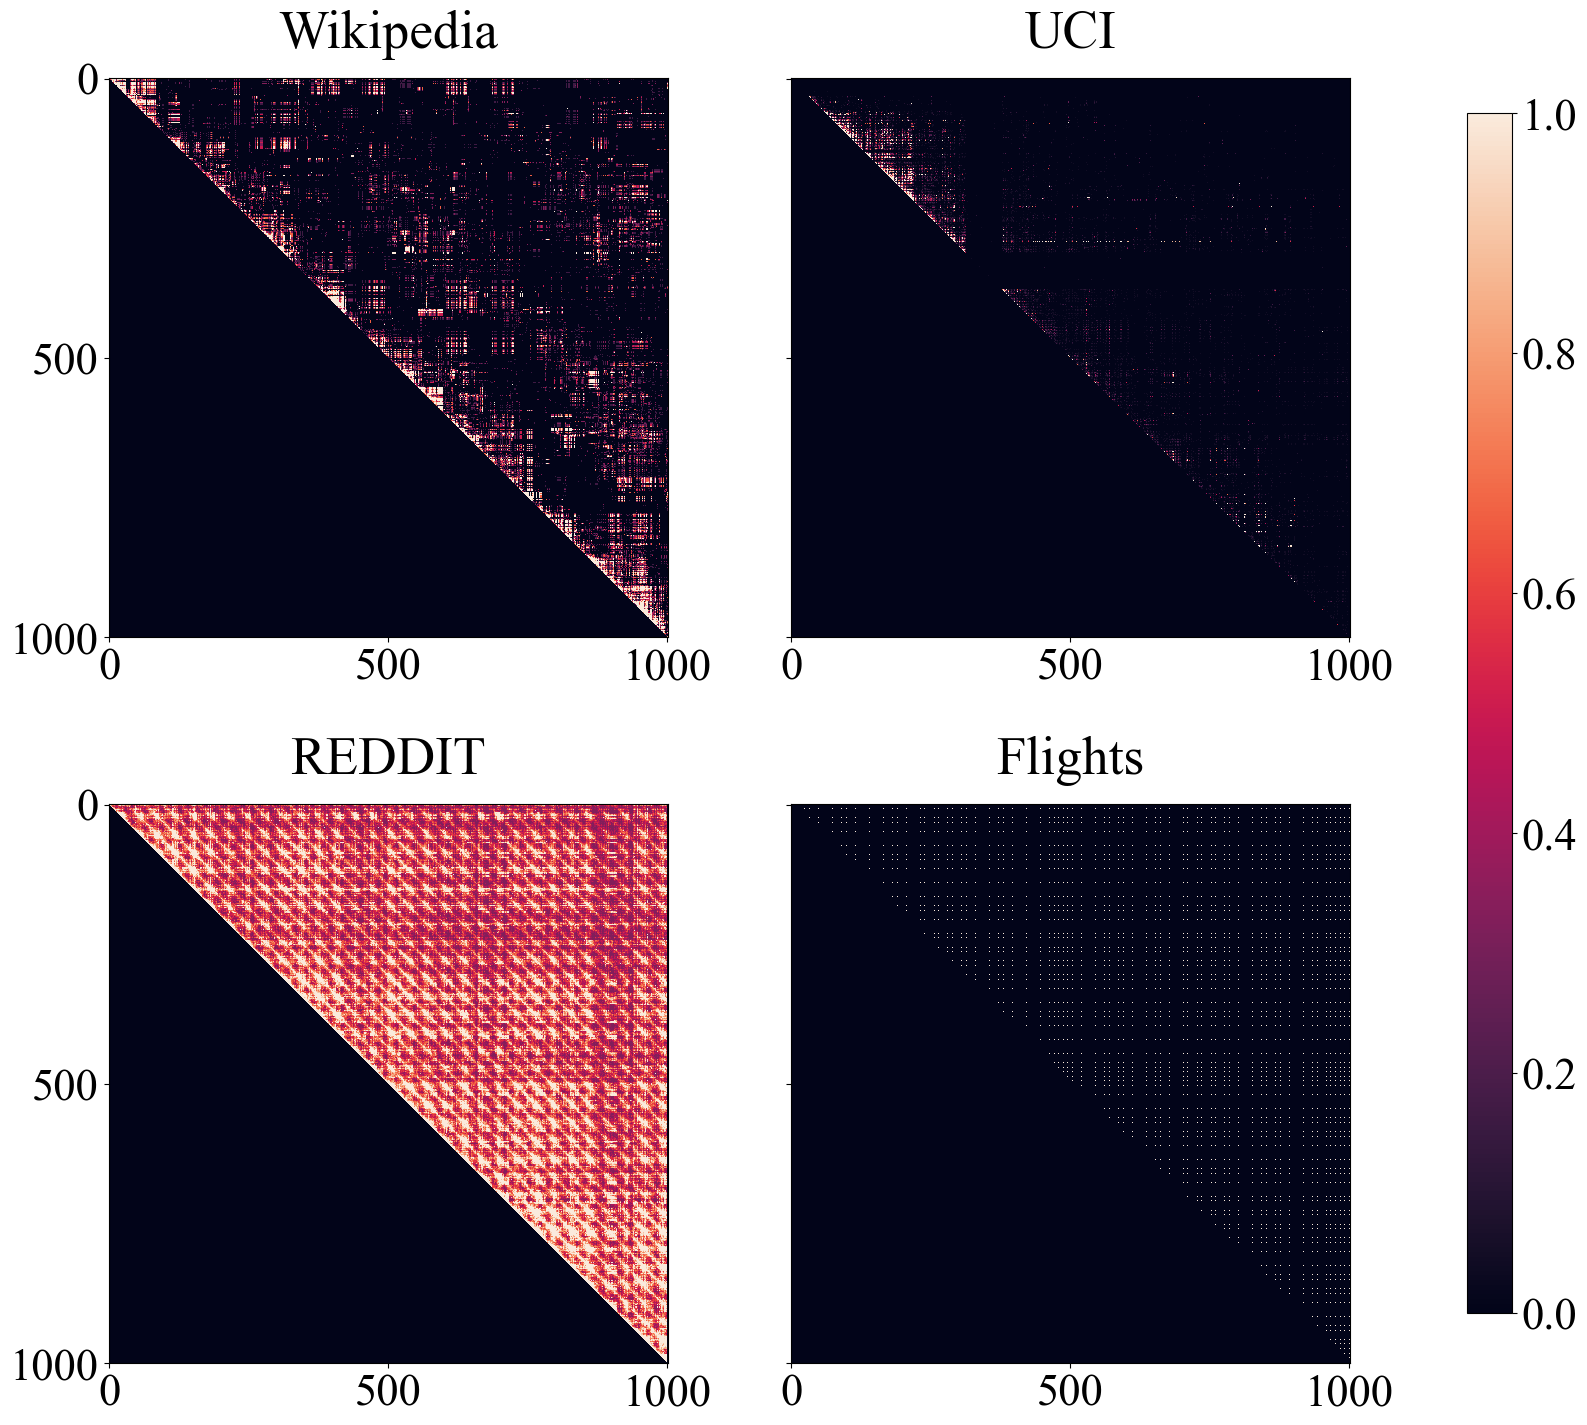

In [93]:
plt.rcParams['font.size'] = args.fontsize
fig, axes = plt.subplots(2, len(datasets)//2, sharex=True, sharey=True, figsize=(15, 15))
cbar_ax = fig.add_axes([1.01, .1, .03, .8])
print('Plotting heatmap...')
for i, ax in enumerate(axes.flat):
    # sns.heatmap(total_matrices[i], vmin=0, vmax=1, ax=ax, cbar=(i==0), xticklabels=int(BINS/5), 
    #             yticklabels=int(BINS/5),square=True, cbar_ax=None if i else cbar_ax)
    im = ax.matshow(total_matrices[i], vmin=0, vmax=1, cmap='rocket',)
    ax.set_xticks(np.arange(0, BINS+1, BINS//2))
    ax.set_yticks(np.arange(0, BINS+1, BINS//2))
    ax.set_title(f'{show_datasets[datasets[i]]}', y=1.04)
    ax.xaxis.set_ticks_position('bottom')
fig.colorbar(im, cax=cbar_ax,)
print('Saving...')
fig.tight_layout()
plt.savefig(f'../figures/recurrence/all_recurrence_analysis.pdf',bbox_inches='tight')